# Real-or-Fake Number Image Classification using CNN

## 1 - Data Exploration and Preparation

In [67]:
# Importing the libraries
import glob
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

### 1.1 - Loading in and setting labels

In [68]:
# Importing the dataset

# Data obtained from: https://www.kaggle.com/competitions/hackathon-online-realfakenumbers/data

# find all the pathnames (no pattern needed)
all_imgs_path0 = glob.glob(r'/Train_1000/Train_1000รูป/0/*')
all_imgs_path1 = glob.glob(r'/Train_1000/Train_1000รูป/1/*')
# downsampling class 1 for an equal distribution of data, result proven better than original dataset
all_imgs_path1 = all_imgs_path1[:487]
# list of all training data
whole = all_imgs_path0 + all_imgs_path1

print(all_imgs_path0[:20])
print(all_imgs_path1[:20])

print("Numbers of All 0 Samples: ",len(all_imgs_path0))
print("Numbers of All 1 Samples: ",len(all_imgs_path1))
print(len(whole))


['/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (133).jpg', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (14).png', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (43).jpg', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (43).png', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (164).jpg', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (14).jpg', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (308).jpg', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (172).jpg', '/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/T

In [69]:
# Set Labels
species = [0,1]
all_labels = []
all_labels = [0 for _ in range(len(all_imgs_path0))] + [1 for _ in range(len(all_imgs_path1))]
print(all_labels[:10], all_labels[-10:])
print(len(all_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
974


### 1.2 - Transformation

In [70]:
transform = transforms.Compose([
                transforms.Resize((96, 96)), 
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize the image #RGB 3 channels within [-1,1]
])

### 1.3 - DataSetClass and Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 96, 96])


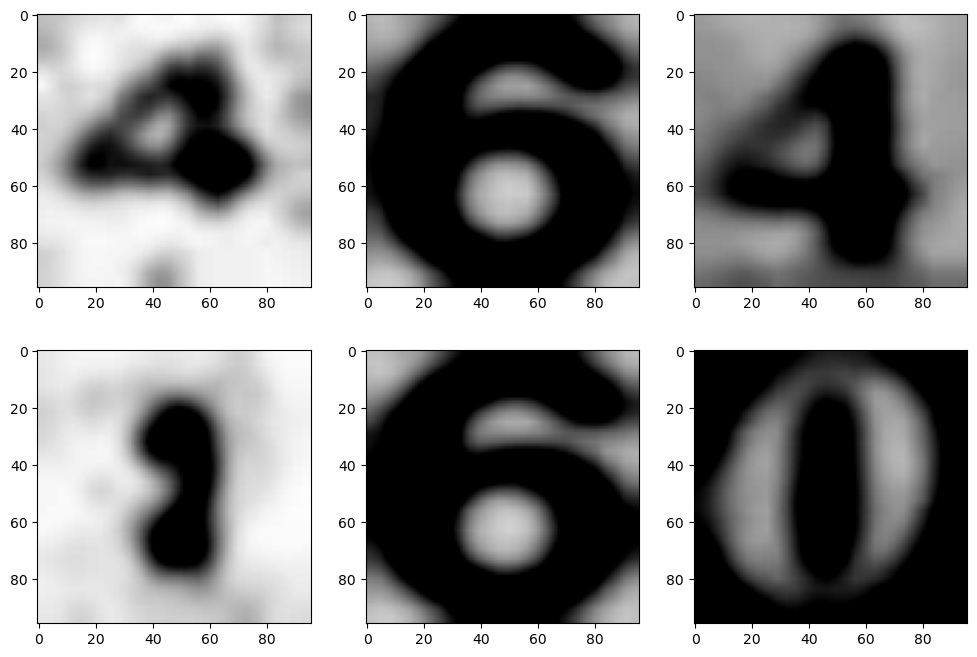

In [71]:
from torch.utils import data

# A dataset class that inherits from torch.utils.data.Dataset

class DataSetClass(data.Dataset):
    def __init__(self, img_paths, labels, transform):
        self.imgs = img_paths
        self.labels = labels
        self.transforms = transform
    def __getitem__(self, index):               
        img = self.imgs[index]
        label = self.labels[index]
        pil_img = Image.open(img).convert('RGB')             
        data = self.transforms(pil_img)
        return data, label
    def __len__(self):
        return len(self.imgs)

BATCH_SIZE = 10
illu_dataset = DataSetClass(whole, all_labels, transform)
illu_datalodaer = data.DataLoader(
                            illu_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
)

# Visualize the data
imgs_batch, labels_batch = next(iter(illu_datalodaer))
print(imgs_batch.shape)

plt.figure(figsize = (12, 8))
for i, (img, label) in enumerate(zip(imgs_batch[: 6], labels_batch[: 6])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
plt.show()

In [72]:
# Shuffling index
index = np.random.permutation(len(whole))

# Apply the shuffling to the lists
all_imgs_path = np.array(whole)[index]
all_labels = np.array(all_labels)[index]
print("Total Number of Samples: ",len(all_imgs_path))

# 70-30 split
s = int(len(all_imgs_path)*0.7)
print("Numbers of Pic for the Training Set: ",s)
print("Numbers of Pic for the Validation Set: ",len(all_imgs_path)-s)

train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s]
test_imgs = all_imgs_path[s:]
test_labels = all_labels[s:]

# Loading in the data to the created DataSetClass then load them in data.DataLoader
trainset = DataSetClass(train_imgs, train_labels, transform)
testset = DataSetClass(test_imgs, test_labels, transform)
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
# (test set in this case is the validation set)

Total Number of Samples:  974
Numbers of Pic for the Training Set:  681
Numbers of Pic for the Validation Set:  293


## 2 - Define and Train The Convolutional Neural Network Model

In [73]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #input: 3, output: 6, kernel_size: 5, current img size: 92
        self.pool = nn.MaxPool2d(2, 2) #kernel_size: 2, stride: 2, , current img size: 46
        self.conv2 = nn.Conv2d(6, 16, 5) #input: 6, output: 16, kernel_size: 5, current img size: 42
        self.fc1 = nn.Linear(16 * 21 * 21, 120) #input: 16*21*21, output: 120
        self.fc2 = nn.Linear(120, 84) #input: 120, output: 84
        self.fc3 = nn.Linear(84, 2) #input:84, output:2 -> 2 classes

    def forward(self, x):
        # apply the convolutional layer followed by relu activation and max-pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten the output tensor before passing it to the fully connected layers
        x = x.view(-1, 16 * 21 * 21)
        # apply the fully connected later followed by relu activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # apply the last fully connected layer with no activation function
        x = self.fc3(x)
        return x
    
# create an instance of the net class and send it to the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7056, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [74]:
# use cross entropy loss because easy to compare probability distribution, closer to the correct label means lower loss
criterion = nn.CrossEntropyLoss()
# Adam (Adaptive learning and Momentum)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# loop over the dataset for 60 epochs
for epoch in range(60):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if device.type == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # apply the model
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        
        # back propagation
        loss.backward()
        # update the model's parameters
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # printing epoch, batch, running lsoss
        if i % 20 == 19: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,    20] loss: 0.638
[1,    40] loss: 0.566
[1,    60] loss: 0.486
[2,    20] loss: 0.654
[2,    40] loss: 0.595
[2,    60] loss: 0.501
[3,    20] loss: 0.513
[3,    40] loss: 0.362
[3,    60] loss: 0.336
[4,    20] loss: 0.402
[4,    40] loss: 0.351
[4,    60] loss: 0.288
[5,    20] loss: 0.403
[5,    40] loss: 0.315
[5,    60] loss: 0.244
[6,    20] loss: 0.323
[6,    40] loss: 0.259
[6,    60] loss: 0.230
[7,    20] loss: 0.266
[7,    40] loss: 0.235
[7,    60] loss: 0.265
[8,    20] loss: 0.204
[8,    40] loss: 0.205
[8,    60] loss: 0.162
[9,    20] loss: 0.138
[9,    40] loss: 0.165
[9,    60] loss: 0.157
[10,    20] loss: 0.151
[10,    40] loss: 0.177
[10,    60] loss: 0.152
[11,    20] loss: 0.088
[11,    40] loss: 0.104
[11,    60] loss: 0.114
[12,    20] loss: 0.111
[12,    40] loss: 0.102
[12,    60] loss: 0.082
[13,    20] loss: 0.173
[13,    40] loss: 0.067
[13,    60] loss: 0.067
[14,    20] loss: 0.041
[14,    40] loss: 0.069
[14,    60] loss: 0.077
[15,    20] loss: 0

## 3 - Results

### 3.1 - Check the accuracy

In [75]:
# test it on the entire validation set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if device.type == 'cuda':
            images = images.to(device)
            inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 92 %


In [76]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in species}
total_pred = {classname: 0 for classname in species}

preds = []
trues = []
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            preds.append(prediction)
            trues.append(label)
            if label == prediction:
                correct_pred[species[label]] += 1
            total_pred[species[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy} %')

preds = [i.item() for i in preds]
trues = [i.item() for i in trues]

Accuracy for class: 0 is 91.21621621621621 %
Accuracy for class: 1 is 93.79310344827586 %


### 3.2 - Result illustration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class: tensor(0) predicted: tensor([0])


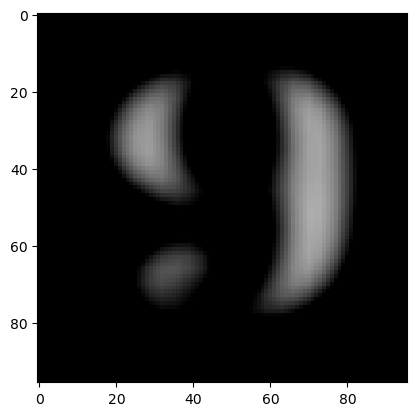

In [77]:
# show result
imgs_batch, labels_batch = next(iter(testloader))
index0 = random.randint(0,31)
img,label = imgs_batch[0], labels_batch[0]
img = img.to(device)
outputs = net(img)
_, predicted = torch.max(outputs.data, 1)
print('True class:', label, 'predicted:', predicted)

img = img.cpu()
img = img.permute(1, 2, 0).numpy()
# plt.subplot(2, 3)
plt.imshow(img)
plt.show()

In [82]:
# Classification Report
def get_report(y_true, y_pred, positive_label=1):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true == positive_label) & (y_pred == positive_label))
    fp = np.sum((y_true != positive_label) & (y_pred == positive_label))
    tn = np.sum((y_true != positive_label) & (y_pred != positive_label))
    fn = np.sum((y_true == positive_label) & (y_pred != positive_label))

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)

    print(len([i for i in y_true if i == 0]))
    print(len([i for i in y_true if i == 1]))

    return tp, fp, tn, fn, precision, recall, f1

get_report(trues, preds)


148
145


(136, 13, 135, 9, 0.912751677852349, 0.9379310344827586, 0.9251700680272109)

## 4 - Application to the real Test set and exporting the results

In [79]:
from torch.utils import data

# TestDataset class that resembles the Dataset class above but no labels
class TestDataset(data.Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img_path = self.file_paths[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

test_imgs_path = glob.glob(r'/Users/clairejaroonjetjumnong/Downloads/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/*')
BATCH_SIZE = 10

transform = transforms.Compose([
                transforms.Resize((96,96)), 
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = TestDataset(test_imgs_path, transform=transform)
testloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

results = []
# evaluation
net.eval()
with torch.no_grad():
    for batch in testloader:
        inputs = batch
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        results.extend(predicted.cpu().numpy())
        

print(results)
print(len(results))

[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 

In [80]:
import pandas as pd
# Turning the results to a dataframe and export it
new_test_imgs_path = []
for name in test_imgs_path:
    name = name.split('/')
    name = name[-1].strip()
    new_test_imgs_path.append(name)
outputs = pd.DataFrame({'img_name': new_test_imgs_path, 'code': results })
outputs

outputs.to_csv("submission.csv", index=False)